# 機器學習作業

1. 資料來源：[https://www.kaggle.com/competitions/boston20200827/](https://www.kaggle.com/competitions/boston20200827/)
2. 要求：
- 完整的機器學習預測流程,包括:資料前處理、視覺化、模型訓練、預測、結果評估等。
- 至少使用兩種模型並比較其效果。

## 資料欄位說明

| 欄位      | 說明                                           |
|-----------|------------------------------------------------|
| ID        | 資料的唯一識別碼。                             |
| CRIM      | 每人均犯罪率。                                 |
| ZN        | 佔地面積超過 25,000 平方英尺的住宅用地比例。   |
| INDUS     | 每鎮非零售業務用地的比例。                     |
| CHAS      | 查爾斯河虛擬變數（= 1 如果地段鄰近河流；否則為 0）。|
| NOX       | 一氧化氮濃度（每 10 百萬分之一）。             |
| RM        | 每棟住宅的平均房間數。                         |
| AGE       | 1940 年之前建造的自住單位比例。                 |
| DIS?      | 到波士頓五個就業中心的加權平均距離。           |
| RAD       | 到放射狀公路的可達性指數。                     |
| TAX       | 每 10,000 美元的房產稅率。                     |
| PTRATIO   | 每個城鎮的學生與教師比例。                     |
| B 1000    | 1000(Bk - 0.63)^2，其中 Bk 是鎮上黑人比例。    |
| LSTAT     | 低收入人口的比例（百分比）。                   |
| PRICE     | 自住單位的中位數價格（以千美元計）。           |


推測自這份資料：[https://www.kaggle.com/competitions/boston-dataset/data?select=boston_data.csv](https://www.kaggle.com/competitions/boston-dataset/data?select=boston_data.csv)


## 載入資料

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv(r'./boston20200827/Boston_train.csv')
test_df = pd.read_csv(r'./boston20200827/Boston_test.csv')
combined_df = pd.concat([train_df, test_df], sort=False)

train_df.head()

,ID,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS?,RAD,TAX,PTRATIO,B 1000,LSTAT,PRICE
0,400,9.91655,0.0,18.10,0,0.693,5.852,77.8,1.5004,24,666,20.2,338.16,29.97,6.3
1,490,0.18337,0.0,27.74,0,0.609,5.414,98.3,1.7554,4,711,20.1,344.05,23.97,7.0
2,491,0.20746,0.0,27.74,0,0.609,5.093,98.0,1.8226,4,711,20.1,318.43,29.68,8.1
3,398,7.67202,0.0,18.10,0,0.693,5.747,98.9,1.6334,24,666,20.2,393.10,19.92,8.5
4,430,9.33889,0.0,18.10,0,0.679,6.380,95.6,1.9682,24,666,20.2,60.72,24.08,9.5


In [3]:
combined_df.describe()

,ID,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS?,RAD,TAX,PTRATIO,B 1000,LSTAT,PRICE
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,352.000000
mean,234.311947,1.420825,12.721239,10.304889,0.077434,0.540816,6.343538,65.557965,4.043570,7.823009,377.442478,18.247124,369.826504,11.441881,19.915625
std,142.775660,2.495894,24.326032,6.797103,0.267574,0.113816,0.666808,28.127025,2.090492,7.543494,151.327573,2.200064,68.554439,6.156437,4.145414
min,1.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,6.300000
25%,113.750000,0.069875,0.000000,4.930000,0.000000,0.447000,5.926750,40.950000,2.354750,4.000000,276.750000,16.800000,377.717500,6.587500,17.375000
50%,226.500000,0.191030,0.000000,8.140000,0.000000,0.519000,6.229000,71.800000,3.550400,5.000000,307.000000,18.600000,392.080000,10.250000,20.300000
75%,339.250000,1.211460,20.000000,18.100000,0.000000,0.605000,6.635000,91.625000,5.401100,7.000000,411.000000,20.200000,396.157500,15.105000,23.000000
max,506.000000,9.966540,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.410000,28.400000


In [4]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 452 entries, 0 to 99
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       452 non-null    int64  
 1   CRIM     452 non-null    float64
 2   ZN       452 non-null    float64
 3   INDUS    452 non-null    float64
 4   CHAS     452 non-null    int64  
 5   NOX      452 non-null    float64
 6   RM       452 non-null    float64
 7   AGE      452 non-null    float64
 8   DIS?     452 non-null    float64
 9   RAD      452 non-null    int64  
 10  TAX      452 non-null    int64  
 11  PTRATIO  452 non-null    float64
 12  B 1000   452 non-null    float64
 13  LSTAT    452 non-null    float64
 14  PRICE    352 non-null    float64
dtypes: float64(11), int64(4)
memory usage: 56.5 KB


## 資料視覺化

<Figure size 5000x5000 with 0 Axes>

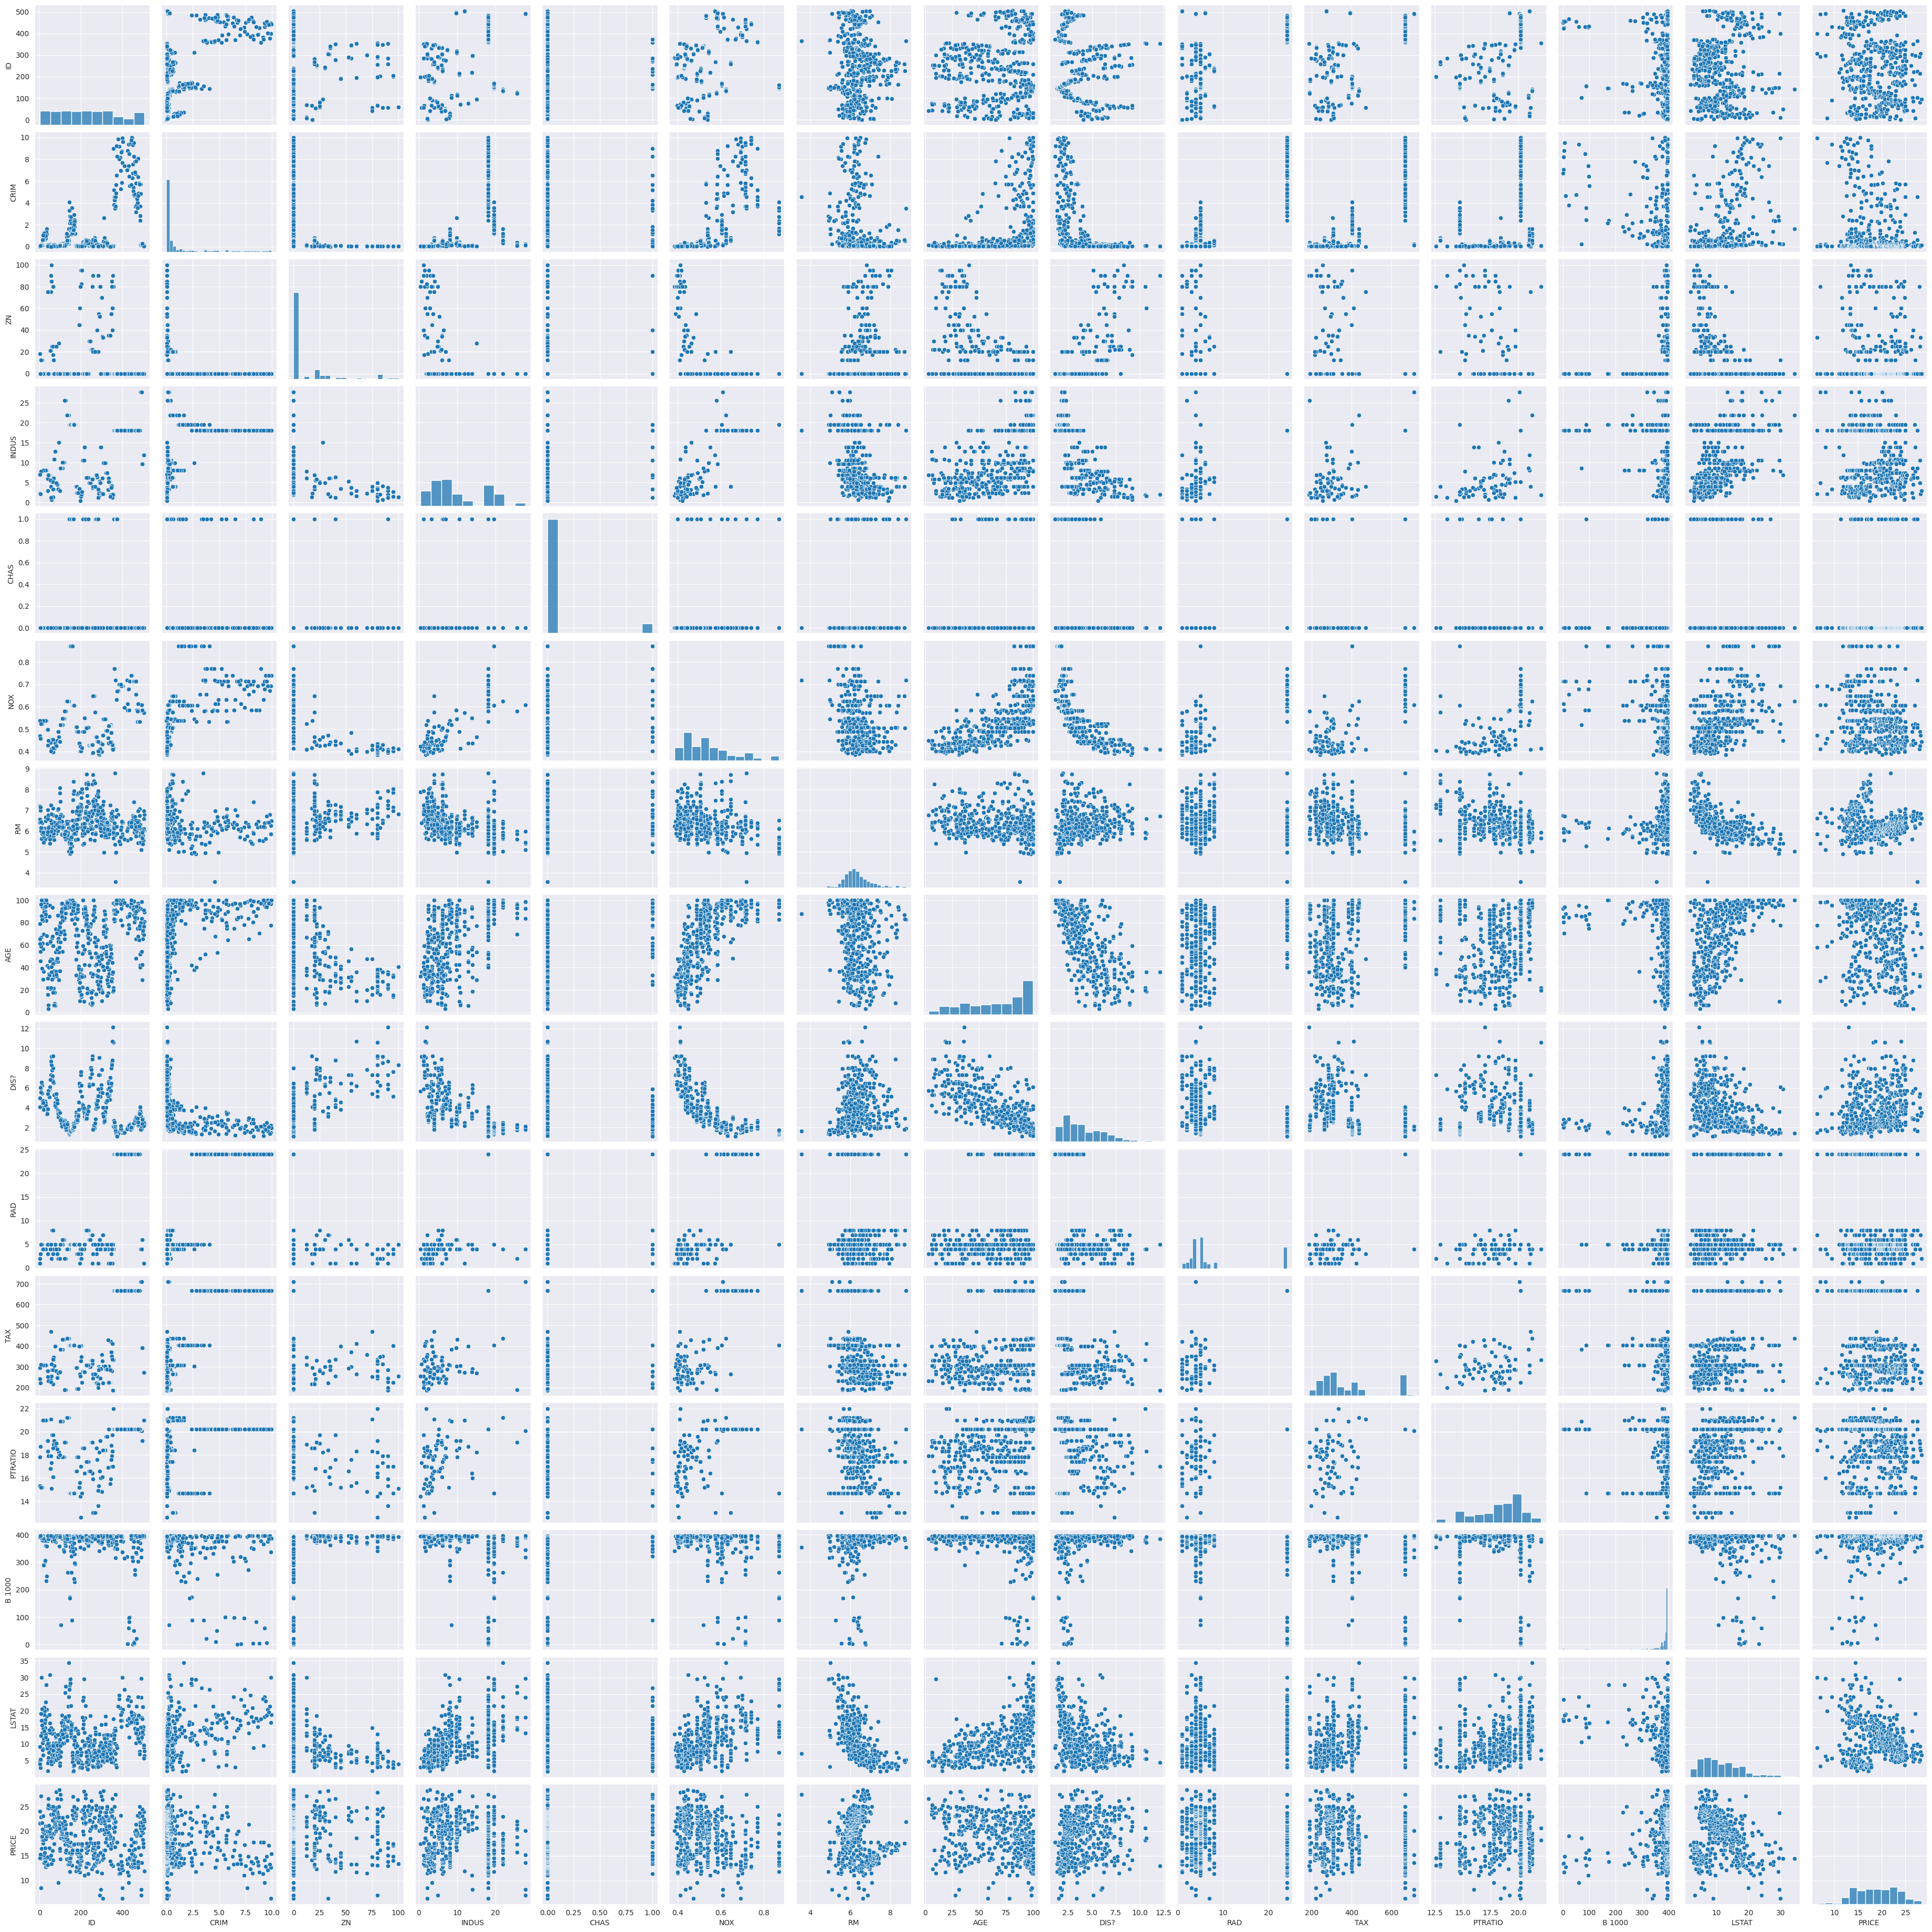

In [5]:
plt.figure(figsize=(50,50))
sns.pairplot(combined_df)

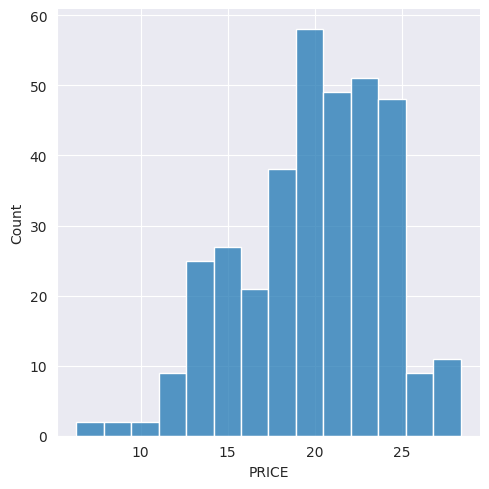

In [6]:
sns.displot(combined_df['PRICE'])

<Axes: >

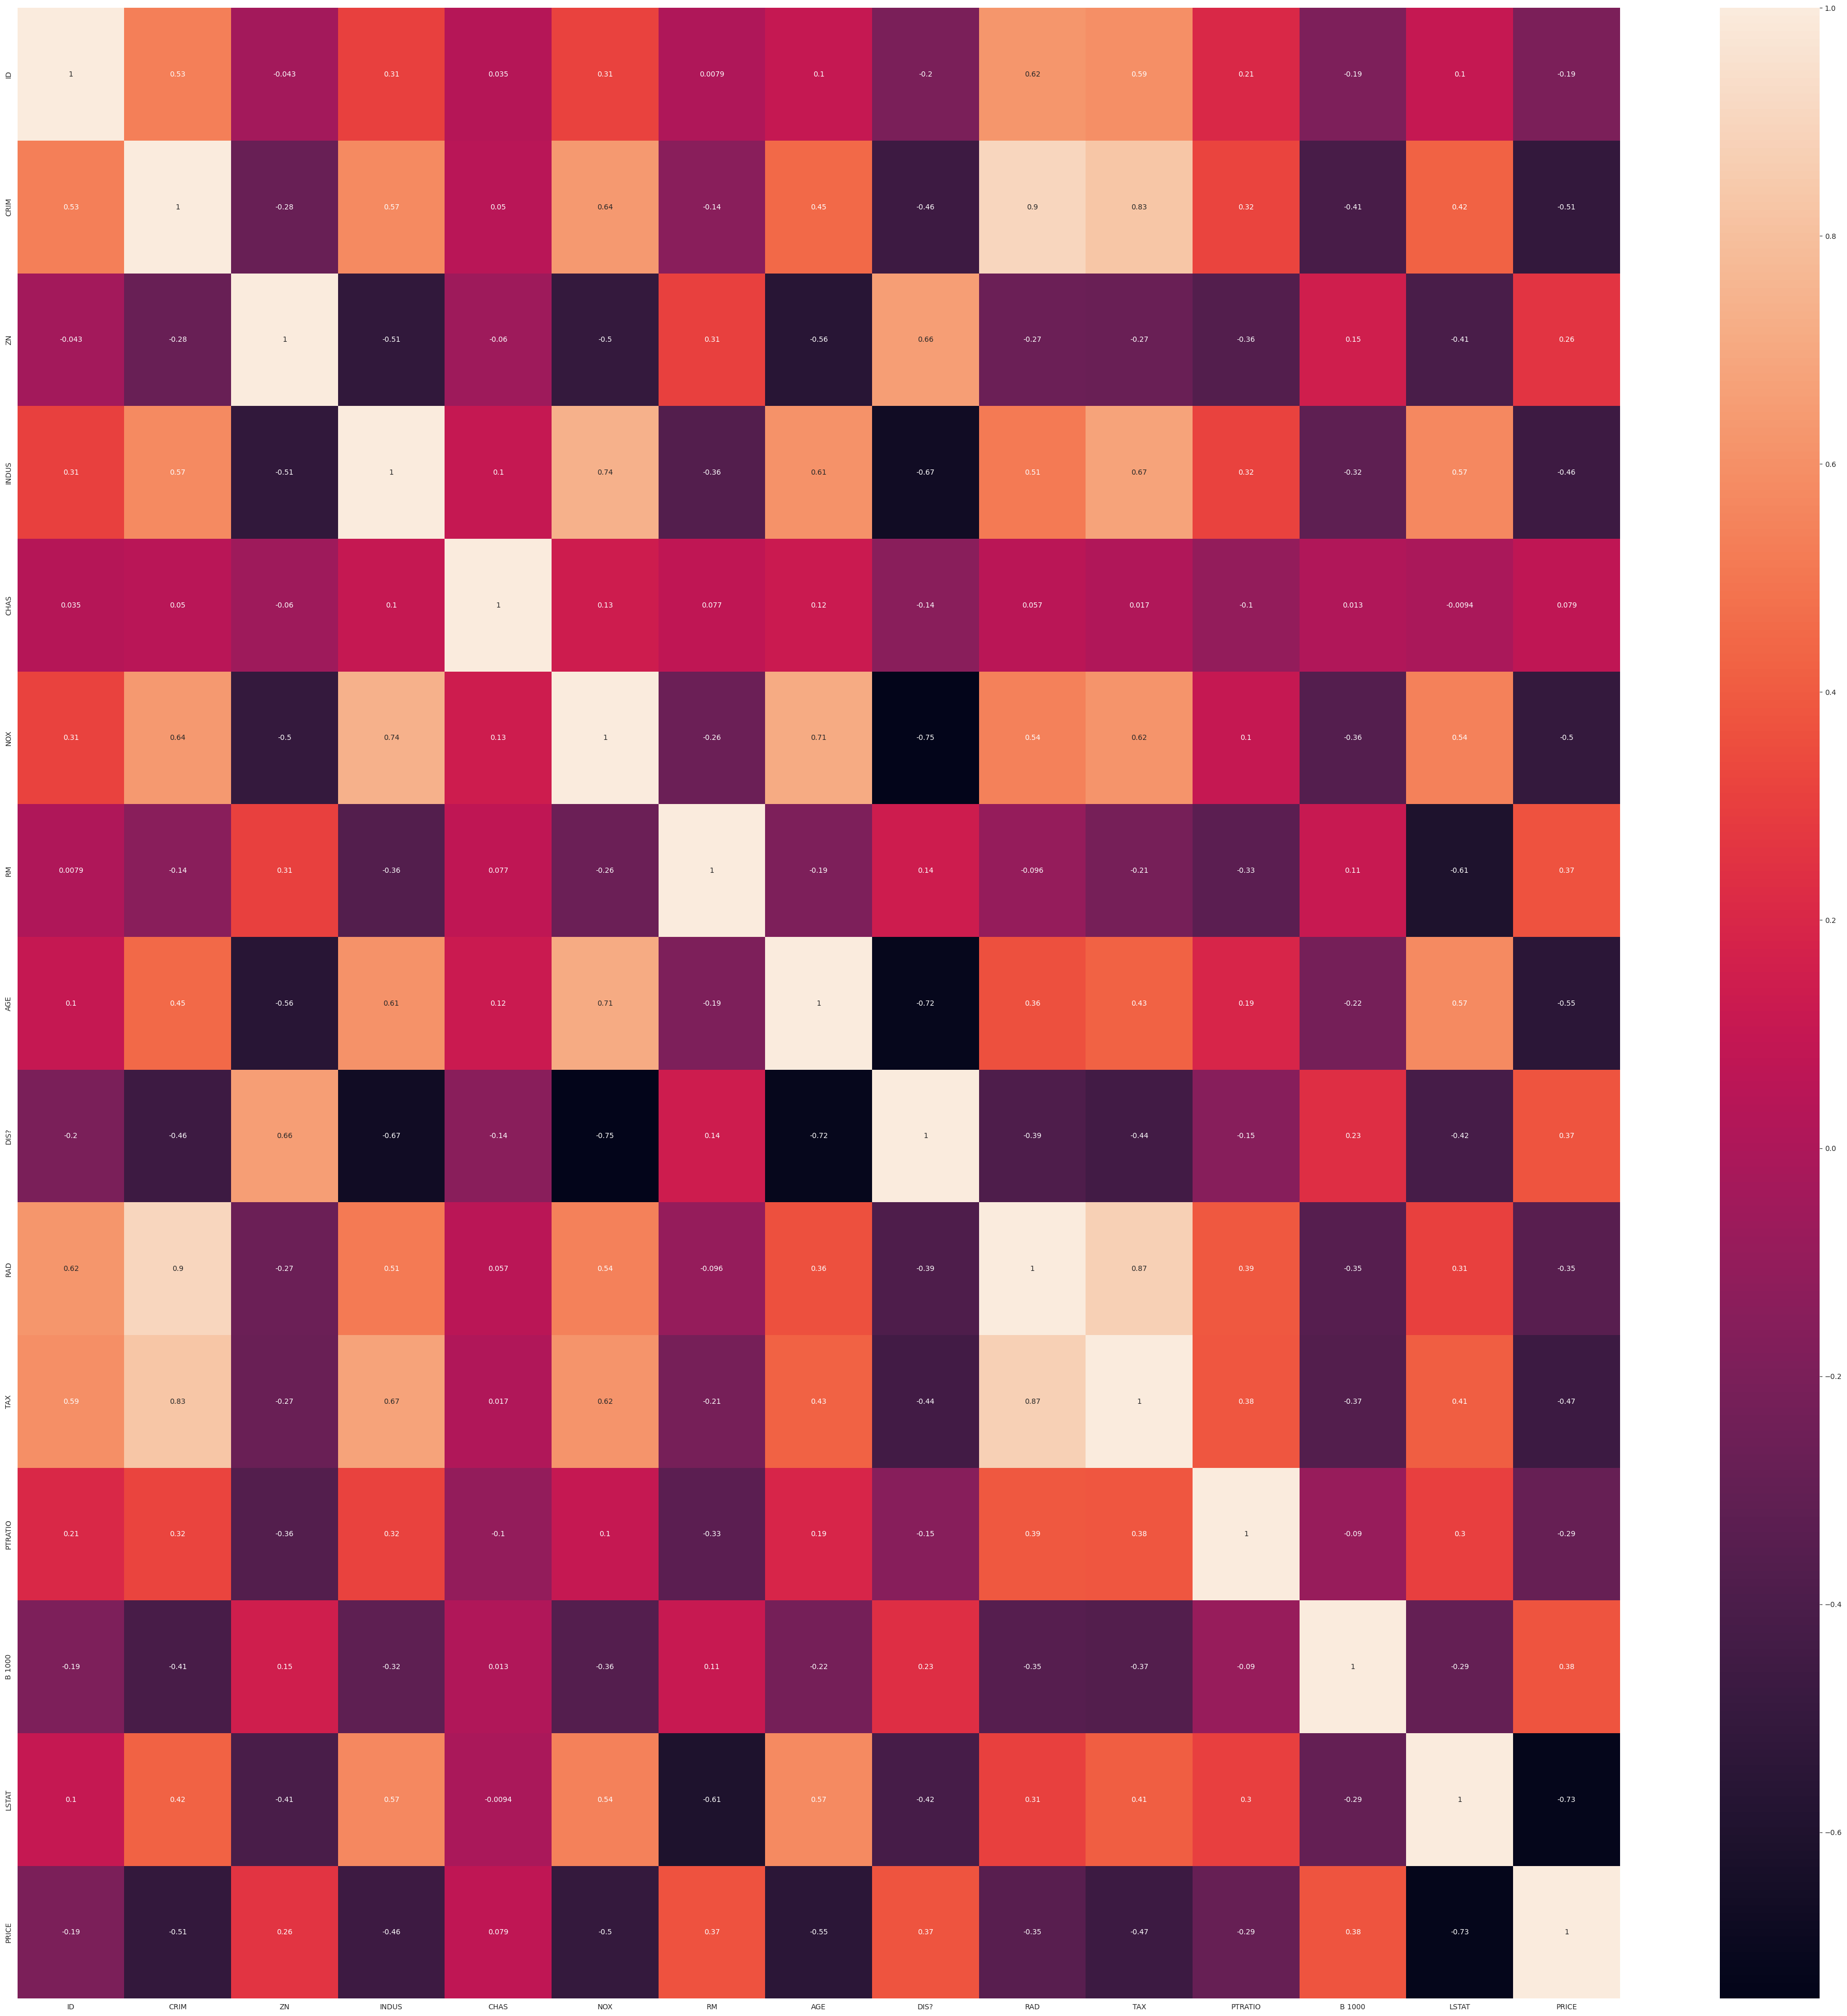

In [7]:
plt.figure(figsize=(50,50))
sns.heatmap(combined_df.corr(), annot=True)

## 資料前處理

In [8]:
combined_df.isnull().sum()

ID           0
CRIM         0
ZN           0
INDUS        0
CHAS         0
NOX          0
RM           0
AGE          0
DIS?         0
RAD          0
TAX          0
PTRATIO      0
B 1000       0
LSTAT        0
PRICE      100
dtype: int64

模型的目標是預測房價（PRICE），因此缺少目標值的數據對於訓練模型來說是沒有意義的。

這些缺失目標值的樣本無法提供有用的信息來幫助模型學習，因此應該將它們從訓練數據中移除。

In [9]:
combined_df = combined_df.dropna(subset=['PRICE'])
combined_df.isnull().sum()

ID         0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS?       0
RAD        0
TAX        0
PTRATIO    0
B 1000     0
LSTAT      0
PRICE      0
dtype: int64

## 特徵工程

In [9]:
# SelectKBest
# PCA 降維